# Question 1 - Comparative Analysis of Recurrent Architectures and Embedding Paradigms

Here, we have chosen the sentiment analysis task with IMDd data. 
* 2 Architectures, bidirectional LSTM and bidirectional GRU is being compared
* 2 Embedding paradigms, Word2Vec (static) and DistilBERT (contextual) are used.

These result in 4 different combinations, mentioned as: BiLSTM_Word2Vec, BiGRU_Word2Vec, BiLSTM_BERT, BiGRU_BERT in the code.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.manifold import TSNE
from datasets import load_dataset
from transformers import DistilBertTokenizer, DistilBertModel
import gensim.downloader as api
from collections import Counter
import re
from tqdm import tqdm
import time

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")


Using device: cuda


In [ ]:
# --- CONFIGURATION ---
MAX_LEN = 200        # Limited sequence length to save memory
BATCH_SIZE = 32
HIDDEN_DIM = 128
NUM_LAYERS = 2
DROPOUT = 0.3
EPOCHS = 10           # Limited in order to save on computation time
W2V_DIM = 300        # Google News Word2Vec dimension

### a) Selection of task -> sentiment analysis, IMDb

In [43]:
# Load IMDb Dataset
dataset = load_dataset("imdb")
print("Dataset loaded.")

Dataset loaded.


In [ ]:
# I have shuffled both in order to get a mix of Positive/Negative values. 
# Without the shuffle, the test data would end up being only negative values.

train_data_raw = dataset['train'].shuffle(seed=42).select(range(10000))
test_data_raw = dataset['test'].shuffle(seed=42).select(range(1000)) 

### b) Implementation of bidirectional LSTM and bidirectional GRU architectures

In [ ]:
## Universal Model Architecture used for both RNN and LSTM 

class ComparativeRNN(nn.Module):
    def __init__(self, rnn_type, embed_mode, hidden_dim, output_dim, n_layers, 
                 dropout, embed_matrix=None):
        super(ComparativeRNN, self).__init__()
        
        self.rnn_type = rnn_type
        self.embed_mode = embed_mode
        self.bidirectional = True
        
        # 1. Embedding Layer
        if embed_mode == 'static':
            # Load Word2Vec weights and freeze them
            self.embedding = nn.Embedding.from_pretrained(embed_matrix, freeze=True)
            input_dim = W2V_DIM
        else:
            # Load DistilBERT and freeze it
            self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
            for param in self.bert.parameters():
                param.requires_grad = False
            input_dim = 768 # DistilBERT size
            
        # 2. RNN Layer
        rnn_args = {
            'input_size': input_dim,
            'hidden_size': hidden_dim,
            'num_layers': n_layers,
            'bidirectional': True,
            'dropout': dropout,
            'batch_first': True
        }
        
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(**rnn_args)
        else:
            self.rnn = nn.GRU(**rnn_args)
            
        # 3. Output Layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim) # *2 for bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, text_or_ids, mask=None):
        # Step 1: Embed
        if self.embed_mode == 'static':
            embedded = self.embedding(text_or_ids)
        else:
            with torch.no_grad():
                embedded = self.bert(input_ids=text_or_ids, attention_mask=mask)[0]

        # Step 2: RNN
        # output: [batch, seq, hidden*2]
        output, _ = self.rnn(embedded)
        
        # Step 3: Pooling (Max over time)
        # This helps capture the strongest signal in the sequence
        hidden = torch.max(output, dim=1)[0]
        
        # Step 4: Classify
        hidden = self.dropout(hidden)
        return self.fc(hidden), hidden


### c) Two embedding paradigms, Word2Vec (static) and DistilBERT (contextual)

In [44]:
print("Downloading/Loading Google Word2Vec (This is ~1.6GB, please wait)...")
w2v_model = api.load('word2vec-google-news-300') 
print("Word2Vec Loaded!")

Downloading/Loading Google Word2Vec (This is ~1.6GB, please wait)...
Word2Vec Loaded!


In [45]:
# Build Vocabulary & Embedding Matrix for Word2Vec
tokenizer_pattern = re.compile(r'\w+')

def simple_tokenize(text):
    return tokenizer_pattern.findall(text.lower())

def create_embedding_matrix(data, w2v_model, max_vocab=25000):
    print("Building Vocabulary from training data...")
    counter = Counter()
    for item in data:
        counter.update(simple_tokenize(item['text']))
    
    # 1. Define Vocab Mapping
    vocab = {"<PAD>": 0, "<UNK>": 1}
    # Keep most common words
    for word, freq in counter.most_common(max_vocab):
        if word in w2v_model: # Only keep words that exist in Word2Vec
            vocab[word] = len(vocab)
            
    # 2. Create Weight Matrix
    matrix = torch.zeros((len(vocab), W2V_DIM))
    
    for word, idx in vocab.items():
        if word in w2v_model:
            matrix[idx] = torch.tensor(w2v_model[word])
        else:
            # Initialize UNK/PAD (though PAD usually stays 0)
            matrix[idx] = torch.randn(W2V_DIM)
            
    return vocab, matrix

vocab, w2v_matrix = create_embedding_matrix(train_data_raw, w2v_model)
print(f"Vocab Size: {len(vocab)}")


Building Vocabulary from training data...
Vocab Size: 20696


In [ ]:
## BERT Tokenizer
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [47]:
class IMDbDataset(Dataset):
    def __init__(self, data, mode, vocab=None):
        self.data = data
        self.mode = mode # 'static' (Word2Vec) or 'contextual' (BERT)
        self.vocab = vocab
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data[idx]['text']
        label = self.data[idx]['label']
        
        if self.mode == 'static':
            # Word2Vec Pipeline
            tokens = simple_tokenize(text)
            tokens = tokens[:MAX_LEN] # Truncate
            indices = [self.vocab.get(t, self.vocab["<UNK>"]) for t in tokens]
            # Pad
            if len(indices) < MAX_LEN:
                indices += [self.vocab["<PAD>"]] * (MAX_LEN - len(indices))
            return torch.tensor(indices), torch.tensor(label, dtype=torch.float)
            
        elif self.mode == 'contextual':
            # BERT Pipeline
            encoding = bert_tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=MAX_LEN,
                return_tensors='pt'
            )
            return {
                'input_ids': encoding['input_ids'].squeeze(),
                'attention_mask': encoding['attention_mask'].squeeze()
            }, torch.tensor(label, dtype=torch.float)

In [ ]:
# Create Loaders
loaders = {
    'static': {
        'train': DataLoader(IMDbDataset(train_data_raw, 'static', vocab), batch_size=BATCH_SIZE, shuffle=True),
        'test': DataLoader(IMDbDataset(test_data_raw, 'static', vocab), batch_size=BATCH_SIZE)
    },
    'contextual': {
        'train': DataLoader(IMDbDataset(train_data_raw, 'contextual'), batch_size=BATCH_SIZE, shuffle=True),
        'test': DataLoader(IMDbDataset(test_data_raw, 'contextual'), batch_size=BATCH_SIZE)
    }
}

### d) Train and evaluate all architecture–embedding combinations

In [ ]:
def evaluate(model, loader, mode):
    model.eval()
    preds_list, labels_list = [], []
    
    with torch.no_grad():
        for batch in loader:
            if mode == 'contextual':
                ids = batch[0]['input_ids'].to(DEVICE)
                mask = batch[0]['attention_mask'].to(DEVICE)
                labels = batch[1].to(DEVICE)
                preds, _ = model(ids, mask)
            else: # static
                text = batch[0].to(DEVICE)
                labels = batch[1].to(DEVICE)
                preds, _ = model(text)
            
            # Convert logits to binary predictions
            probs = torch.sigmoid(preds.squeeze(1))
            preds_list.extend((probs > 0.5).float().cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
            
    # Calculate both required metrics
    acc = accuracy_score(labels_list, preds_list)
    f1 = f1_score(labels_list, preds_list, average='macro')
    return acc, f1

In [ ]:
def train_model(model_name, rnn_type, embed_mode):
    print(f"\n--- Training {model_name} ---")
    
    # Setup
    model = ComparativeRNN(rnn_type, embed_mode, HIDDEN_DIM, 1, NUM_LAYERS, DROPOUT, w2v_matrix)
    model = model.to(DEVICE)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss()
    
    train_loader = loaders[embed_mode]['train']
    test_loader = loaders[embed_mode]['test']
    
    # Tracking Metrics for Convergence Efficiency
    history = {'loss': [], 'val_acc': [], 'val_f1': []}
    start_total_time = time.time()    
    
    for epoch in range(EPOCHS):
        start_epoch_time = time.time()
        model.train()
        epoch_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
            optimizer.zero_grad()
            
            if embed_mode == 'contextual':
                ids = batch[0]['input_ids'].to(DEVICE)
                mask = batch[0]['attention_mask'].to(DEVICE)
                labels = batch[1].to(DEVICE)
                preds, _ = model(ids, mask)
            else:
                text = batch[0].to(DEVICE)
                labels = batch[1].to(DEVICE)
                preds, _ = model(text)
                
            loss = criterion(preds.squeeze(1), labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # End of Epoch Stats
        epoch_time = time.time() - start_epoch_time
        avg_loss = epoch_loss / len(train_loader)
        val_acc, val_f1 = evaluate(model, test_loader, embed_mode)
        
        history['loss'].append(avg_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f} | Time: {epoch_time:.1f}s")
        
    total_time = time.time() - start_total_time
    
    # Return stats for the final table
    stats = {
        'Model': model_name,
        'Accuracy': val_acc,
        'Macro-F1': val_f1,
        'Total Time (s)': total_time,
        'Time/Epoch (s)': total_time / EPOCHS,
        'Loss History': history['loss'] # For convergence plotting
    }
    
    return model, stats

In [ ]:
# Store trained models for visualization
trained_models = {}
all_stats = []

# Run all 4 Combinations
configs = [
    ('BiLSTM_Word2Vec', 'LSTM', 'static'),
    ('BiGRU_Word2Vec', 'GRU', 'static'),
    ('BiLSTM_BERT', 'LSTM', 'contextual'),
    ('BiGRU_BERT', 'GRU', 'contextual')
]

for name, rnn, mode in configs:
    model, stats = train_model(name, rnn, mode)
    trained_models[name] = model
    all_stats.append(stats)



--- Training BiLSTM_Word2Vec ---


Epoch 1:   2%|▏         | 6/313 [00:00<00:05, 59.93it/s]

Epoch 1 | Loss: 0.5895 | Acc: 0.7980 | F1: 0.7980 | Time: 5.2s


Epoch 2 | Loss: 0.3902 | Acc: 0.8240 | F1: 0.8232 | Time: 5.1s


Epoch 3 | Loss: 0.3486 | Acc: 0.8430 | F1: 0.8429 | Time: 5.1s


Epoch 4 | Loss: 0.3136 | Acc: 0.8500 | F1: 0.8498 | Time: 5.1s


Epoch 5 | Loss: 0.2919 | Acc: 0.8470 | F1: 0.8458 | Time: 5.1s


Epoch 6 | Loss: 0.2583 | Acc: 0.8330 | F1: 0.8327 | Time: 5.1s


Epoch 7 | Loss: 0.2271 | Acc: 0.8550 | F1: 0.8548 | Time: 5.1s


Epoch 8 | Loss: 0.1921 | Acc: 0.8560 | F1: 0.8560 | Time: 5.1s


Epoch 9 | Loss: 0.1650 | Acc: 0.8480 | F1: 0.8477 | Time: 5.1s


Epoch 10 | Loss: 0.1206 | Acc: 0.8480 | F1: 0.8480 | Time: 5.2s

--- Training BiGRU_Word2Vec ---


Epoch 1 | Loss: 0.5785 | Acc: 0.8040 | F1: 0.8038 | Time: 4.3s


Epoch 2 | Loss: 0.3775 | Acc: 0.8380 | F1: 0.8377 | Time: 4.3s


Epoch 3 | Loss: 0.3250 | Acc: 0.8460 | F1: 0.8458 | Time: 4.3s


Epoch 4 | Loss: 0.2954 | Acc: 0.8410 | F1: 0.8404 | Time: 4.3s


Epoch 5 | Loss: 0.2710 | Acc: 0.8560 | F1: 0.8560 | Time: 4.4s


Epoch 6 | Loss: 0.2420 | Acc: 0.8570 | F1: 0.8563 | Time: 4.4s


Epoch 7 | Loss: 0.2059 | Acc: 0.8530 | F1: 0.8530 | Time: 4.3s


Epoch 8 | Loss: 0.1695 | Acc: 0.8590 | F1: 0.8588 | Time: 4.3s


Epoch 9 | Loss: 0.1323 | Acc: 0.8560 | F1: 0.8560 | Time: 4.3s


Epoch 10 | Loss: 0.1070 | Acc: 0.8610 | F1: 0.8610 | Time: 4.4s

--- Training BiLSTM_BERT ---


Epoch 1 | Loss: 0.3999 | Acc: 0.8520 | F1: 0.8519 | Time: 82.0s


Epoch 2 | Loss: 0.3183 | Acc: 0.8480 | F1: 0.8478 | Time: 81.6s


Epoch 3 | Loss: 0.2890 | Acc: 0.8370 | F1: 0.8360 | Time: 81.6s


Epoch 4 | Loss: 0.2670 | Acc: 0.8670 | F1: 0.8670 | Time: 81.8s


Epoch 5 | Loss: 0.2498 | Acc: 0.8610 | F1: 0.8610 | Time: 82.1s


Epoch 6 | Loss: 0.2237 | Acc: 0.8470 | F1: 0.8462 | Time: 81.7s


Epoch 7 | Loss: 0.2045 | Acc: 0.8630 | F1: 0.8630 | Time: 82.5s


Epoch 8 | Loss: 0.1709 | Acc: 0.8450 | F1: 0.8445 | Time: 83.4s


Epoch 9 | Loss: 0.1504 | Acc: 0.8520 | F1: 0.8517 | Time: 83.5s


Epoch 10 | Loss: 0.1319 | Acc: 0.8590 | F1: 0.8577 | Time: 82.9s

--- Training BiGRU_BERT ---


Epoch 1 | Loss: 0.4070 | Acc: 0.8650 | F1: 0.8648 | Time: 81.5s


Epoch 2 | Loss: 0.3124 | Acc: 0.8700 | F1: 0.8700 | Time: 91.4s


Epoch 3 | Loss: 0.2808 | Acc: 0.8720 | F1: 0.8720 | Time: 103.3s


Epoch 4 | Loss: 0.2581 | Acc: 0.8700 | F1: 0.8693 | Time: 98.1s


Epoch 5 | Loss: 0.2286 | Acc: 0.8750 | F1: 0.8750 | Time: 88.3s


Epoch 6 | Loss: 0.1993 | Acc: 0.8800 | F1: 0.8800 | Time: 81.3s


Epoch 7 | Loss: 0.1694 | Acc: 0.8920 | F1: 0.8919 | Time: 80.6s


Epoch 8 | Loss: 0.1246 | Acc: 0.8640 | F1: 0.8636 | Time: 81.5s


Epoch 9 | Loss: 0.1064 | Acc: 0.8570 | F1: 0.8565 | Time: 82.1s


Epoch 10 | Loss: 0.0765 | Acc: 0.8690 | F1: 0.8686 | Time: 79.9s



=== Final Comparative Analysis ===
             Model  Accuracy  Macro-F1  Total Time (s)  Time/Epoch (s)
0  BiLSTM_Word2Vec     0.848  0.847961       55.182241        5.518224
1   BiGRU_Word2Vec     0.861  0.860983       47.029880        4.702988
2      BiLSTM_BERT     0.859  0.857716      898.341425       89.834143
3       BiGRU_BERT     0.869  0.868631      947.664103       94.766410


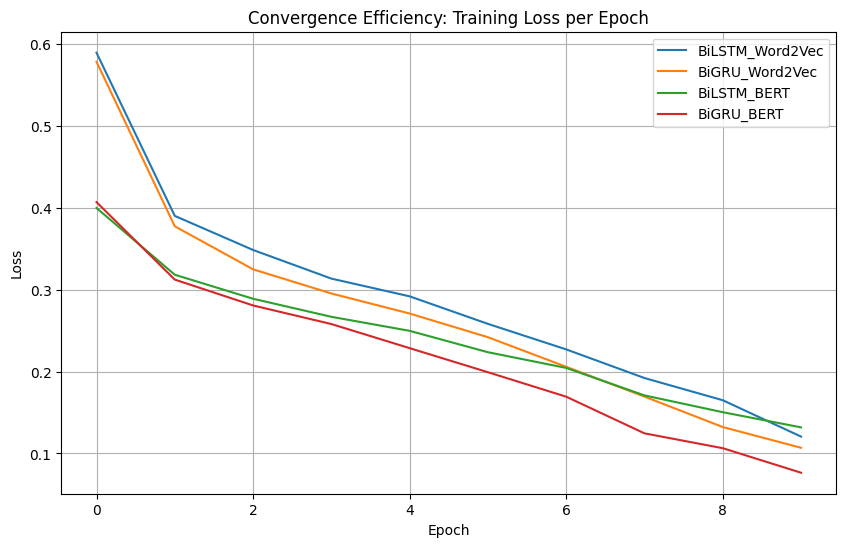

In [60]:
# --- Summary Table (Convergence Efficiency) ---
df_results = pd.DataFrame(all_stats).drop(columns=['Loss History'])
print("\n=== Final Comparative Analysis ===")
print(df_results)

# --- Convergence Plot (Loss over Time) ---
plt.figure(figsize=(10, 6))

for stat in all_stats:
    # Plot the loss history we saved earlier
    plt.plot(stat['Loss History'], label=stat['Model'])

plt.title("Convergence Efficiency: Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### e) Visualize latent representations with t-SNE to reveal structural patterns

Running t-SNE on all models (this might take a moment)...


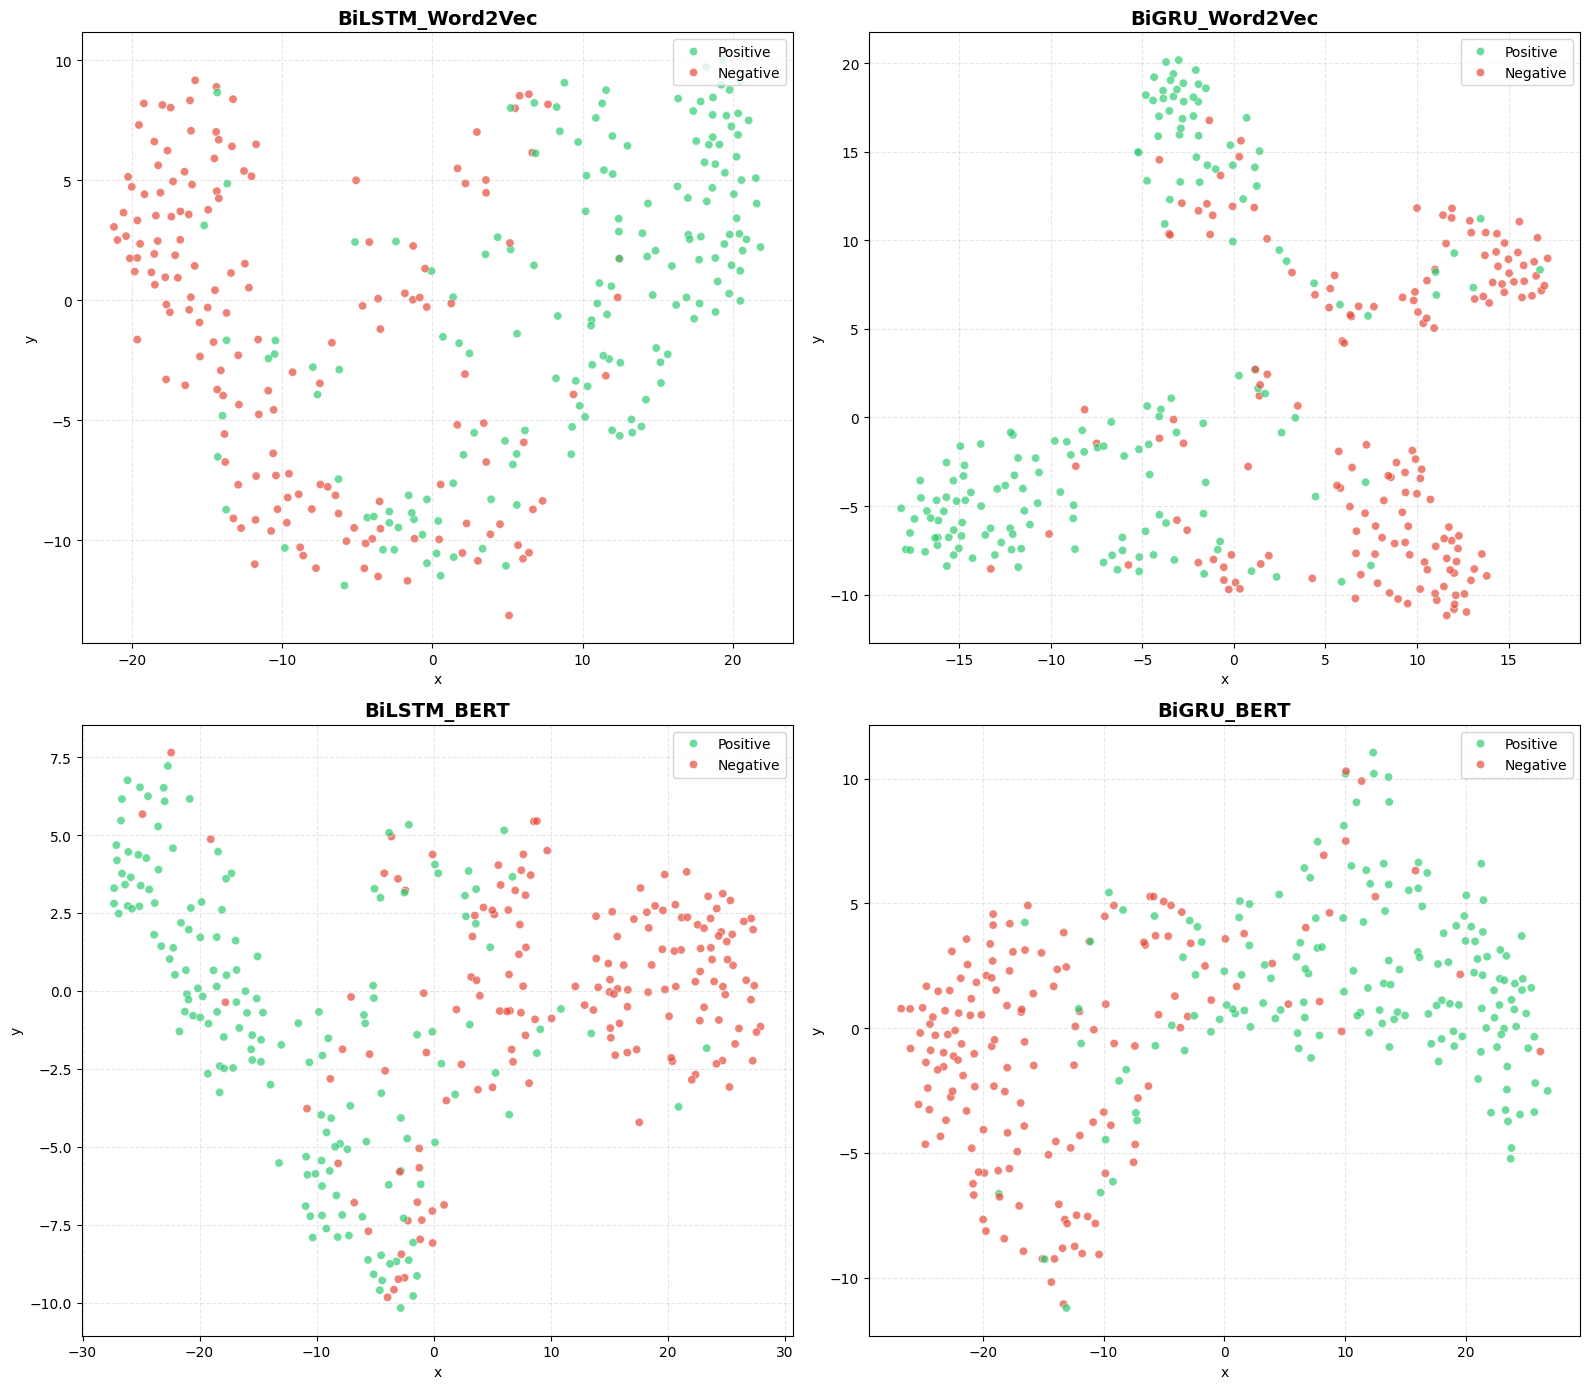

In [ ]:
def plot_all_tsne(trained_models, loaders):
    # Create a 2x2 grid for the 4 models
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten() # Flatten 2D grid to 1D list for easy looping
    
    # List of configs to plot
    configs = [
        ('BiLSTM_Word2Vec', 'static'),
        ('BiGRU_Word2Vec', 'static'),
        ('BiLSTM_BERT', 'contextual'),
        ('BiGRU_BERT', 'contextual')
    ]
    
    print("Running t-SNE on all models (this might take a moment)...")
    
    for i, (model_name, mode) in enumerate(configs):
        ax = axes[i]
        model = trained_models[model_name]
        loader = loaders[mode]['test']
        
        # 1. Collect Vectors
        model.eval()
        vectors = []
        labels = []
        
        with torch.no_grad():
            count = 0
            for batch in loader:
                if count > 300: break # Limit samples for speed/clarity
                
                if mode == 'contextual':
                    ids = batch[0]['input_ids'].to(DEVICE)
                    mask = batch[0]['attention_mask'].to(DEVICE)
                    lbl = batch[1]
                    _, hidden = model(ids, mask)
                else:
                    text = batch[0].to(DEVICE)
                    lbl = batch[1]
                    _, hidden = model(text)
                
                vectors.append(hidden.cpu().numpy())
                labels.append(lbl.cpu().numpy())
                count += len(lbl)
                
        vectors = np.concatenate(vectors, axis=0)
        labels = np.concatenate(labels, axis=0)
        
        # 2. Compute t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
        v_2d = tsne.fit_transform(vectors)
        
        # 3. Prepare Data with Semantic Labels
        # Map 0 -> Negative, 1 -> Positive
        label_text = ['Positive' if l == 1 else 'Negative' for l in labels]
        
        df = pd.DataFrame({
            'x': v_2d[:,0], 
            'y': v_2d[:,1], 
            'Sentiment': label_text
        })
        
        # 4. Plot on the specific subplot axis
        sns.scatterplot(data=df, x='x', y='y', hue='Sentiment', 
                        palette={'Positive': '#2ecc71', 'Negative': '#e74c3c'}, 
                        alpha=0.7, ax=ax)
        
        ax.set_title(model_name, fontsize=14, fontweight='bold')
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run the new function
plot_all_tsne(trained_models, loaders)